In [1]:
from app.rl.tictactoe.t3_test import T3Model, convert_inputs
from gym_tic_tac_toe.envs.tic_tac_toe_env import TicTacToeEnv, Pix
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = T3Model(embed_dim=16, attentions_depth=2).double().to(device)

In [4]:

def play(player_1, player_2, render=False):
    env = TicTacToeEnv()
    env.reset()
    piece1 = Pix.X if torch.rand(1) > 0.5 else Pix.O
    env.player = piece1
    if render:
        env.render()

    info = {}
    is_done = False
    while not is_done:
        player = player_1 if env.player == piece1 else player_2
        action = player(env)
        state, reward, is_done, info = env.step(action)
        if render:
            env.render()

    won = info.get('won')
    if won:
        return 1 if won == piece1.string else 2
    return 0


def random_player(env, legal_actions=None):
    legal_actions = legal_actions if legal_actions is not None else env.get_legal_actions()
    random_idx = int(torch.randint(low=0, high=len(legal_actions), size=(1,))[0])
    return legal_actions[random_idx]


class AIPlayer:
    def __init__(self, model):
        self.model = model

    def __call__(self, env, legal_actions=None):
        legal_actions = legal_actions if legal_actions is not None else env.get_legal_actions()
        xs = [convert_inputs(env.state, env.player)]
        xs = torch.stack(xs).long().to(device)
        was_train = self.model.training

        self.model.eval()
        with torch.no_grad():
            yh = self.model(xs)  # yh shape: (batch, 9)

        if was_train:
            self.model.train()

        legal_probs = F.softmax(yh[0, legal_actions], 0)
        action_idx = int(legal_probs.argmax())

        return legal_actions[action_idx]




99: 14.244809375184907, plays: (16, 37, 47)


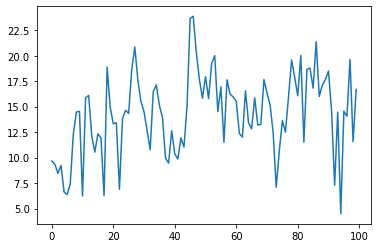

In [ ]:

def get_credits(t, gamma):
    credits = []
    prev_credit = 1
    for i in range(t):
        credits.append(prev_credit)
        prev_credit *= gamma
    return torch.tensor(list(reversed(credits))).double().to(device)


def get_returns(stats, gamma):
    total_t = len(stats)
    returns = []
    prev_return = 0
    for t in range(total_t):
        prev_return = stats[total_t - t -1][1] + (gamma * prev_return)
        returns.append(prev_return)
    return torch.tensor(list(reversed(returns))).double().to(device)


def get_loss(stats):
    loss = 0
    for i_env in range(len(stats)):
        returns = get_returns(stats[i_env], gamma=0.75)

        probs = torch.stack([stat[0] for stat in stats[i_env]])
        probs = torch.log(probs)

        credits = get_credits(len(stats[i_env]), gamma=0.75)

        loss += torch.sum(probs * credits * returns) / len(stats[i_env])
    return -1 * loss / len(stats)


def train():

    batch_size = 64
    epochs = 1000

    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=1e-4)
    envs = [TicTacToeEnv() for _ in range(batch_size)]
    losses = []
    opponent = AIPlayer(model)

    for epoch in range(epochs):
        # Before game starts

        me_idx_bool = torch.arange(batch_size) > (batch_size - 1) / 2
        stats = [[] for _ in range(batch_size)]
        is_dones = [False for _ in range(batch_size)]
        _ = [env.reset() for env in envs]

        # Monte Carlo loop
        for t in range(15):
            legal_actions = [env.get_legal_actions() for env in envs]

            xs = [convert_inputs(envs[i].state, envs[i].player) for i in range(batch_size)]
            xs = torch.stack(xs).long().to(device)

            yh = model(xs)  # yh shape: (batch, 9)

            for i in range(batch_size):
                if not is_dones[i]:

                    # Is current player AI or other?
                    ai_piece = Pix.X if me_idx_bool[i] else Pix.O
                    if envs[i].player == ai_piece:
                        legal_probs = F.softmax(yh[i, legal_actions[i]], 0)
                        action_idx = int(torch.multinomial(legal_probs, 1).squeeze())

                        state, reward, is_done, info = envs[i].step(legal_actions[i][action_idx])

                        prob = legal_probs[action_idx]
                        stats[i].append([prob, reward])
                    else:
                        action = opponent(envs[i], legal_actions[i])
                        _, _, is_done, _ = envs[i].step(action)

                    is_dones[i] = is_done

            if all(is_dones):
                break

        loss = get_loss(stats)

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            plays = [play(AIPlayer(model), opponent) for _ in range(50)]
            plays = plays + [play(opponent, AIPlayer(model)) for _ in range(50)]
            winners = torch.tensor(plays).float()

            draws = len(torch.nonzero(winners == 0))
            wins = len(torch.nonzero(winners == 1))
            loses = len(torch.nonzero(winners == 2))

            print(f'{epoch}: {np.mean(losses)}, plays: {draws, wins, loses}')

            #if (epoch + 1) % 1000 == 0:
            plt.plot(losses)
            plt.show()

            losses = []
            opponent.model = model


train()


In [6]:
plays = [play(AIPlayer(model), random_player) for _ in range(50)]
plays = plays + [play(random_player, AIPlayer(model)) for _ in range(50)]
winners = torch.tensor(plays).float()

draws = len(torch.nonzero(winners == 0))
wins = len(torch.nonzero(winners == 1))
loses = len(torch.nonzero(winners == 2))

draws, wins, loses

(10, 60, 30)

In [8]:
play(random_player, AIPlayer(model), render=True)

___
___
___

___
__X
___

___
__X
__O

___
X_X
__O

___
XOX
__O

___
XOX
_XO

O__
XOX
_XO



2